# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [35]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [36]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())
# mcolors.__dict__
# colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [ ]:
# Get cluster data
# data_path = ceph_path / "22-07-15_aLc1_line16000_100umconf"
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
# data_path = (
#     ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                            :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust_cent_list = []
    clust_label_list = []
    for i in range(time_arr.size):
        clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
            com_arr[:, :, i], thresh=40)
        clust_cent_list += [cluster_centers]
        clust_label_list += [cluster_label_inds]

data_dict = {
    "time_arr": time_arr.tolist(),
    "cluster_center_list" : [[c.tolist() for c in t] for t in clust_cent_list],
    "cluster_label_list" : [[c.tolist() for c in t] for t in clust_label_list],
}


number of estimated clusters : 4
number of thresholded clusters : 0
number of estimated clusters : 9
number of thresholded clusters : 0
number of estimated clusters : 12
number of thresholded clusters : 1
number of estimated clusters : 9
number of thresholded clusters : 1
number of estimated clusters : 8
number of thresholded clusters : 1
number of estimated clusters : 9
number of thresholded clusters : 1
number of estimated clusters : 12
number of thresholded clusters : 1
number of estimated clusters : 14
number of thresholded clusters : 1
number of estimated clusters : 10
number of thresholded clusters : 2
number of estimated clusters : 10
number of thresholded clusters : 4
number of estimated clusters : 12
number of thresholded clusters : 1
number of estimated clusters : 10
number of thresholded clusters : 4
number of estimated clusters : 8
number of thresholded clusters : 3
number of estimated clusters : 11
number of thresholded clusters : 2
number of estimated clusters : 10
number

In [28]:
with (data_path / 'analysis/clust_data.yaml').open('w') as yf:
    yaml.dump(data_dict, yf)

In [5]:
with (data_path / 'analysis/clust_data.yaml').open('r') as yf:
    data_dict = yaml.safe_load(yf)
time_arr = np.array(data_dict['time_arr'])
cluster_center_list = data_dict['cluster_center_list']
cluster_label_list = data_dict['cluster_label_list']

In [ ]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, nskip=1)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


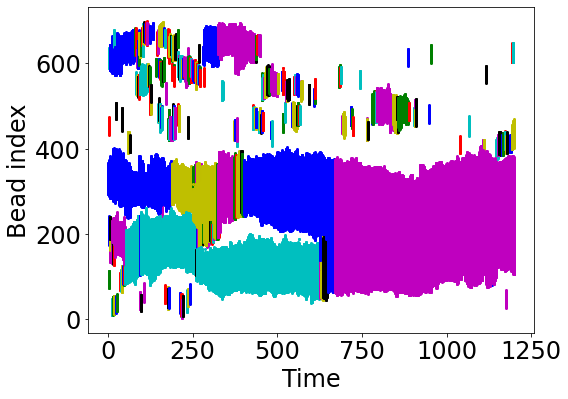

In [9]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [10]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, nskip=2)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


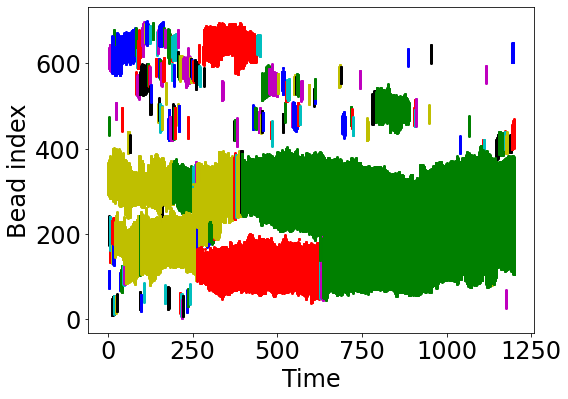

In [11]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [12]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, nskip=5)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


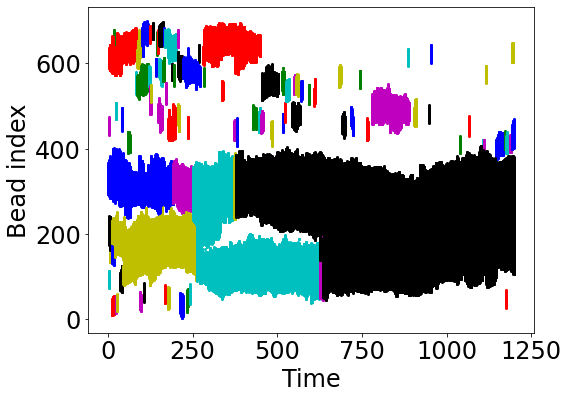

In [13]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [14]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, nskip=10)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


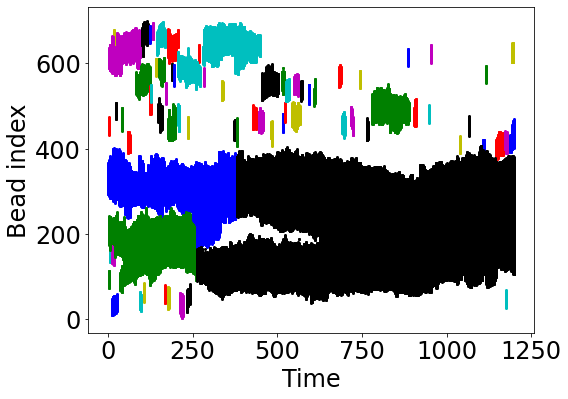

In [15]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [16]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, nskip=20)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


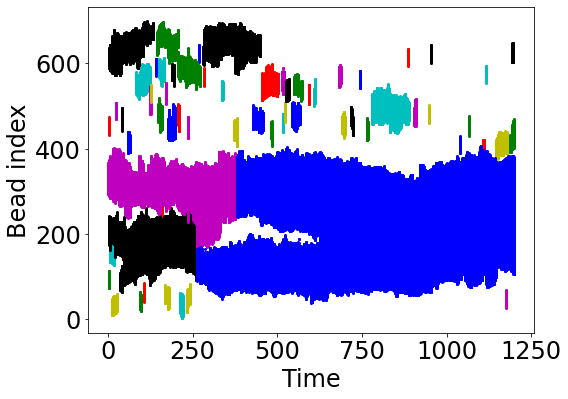

In [17]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [47]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=40)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


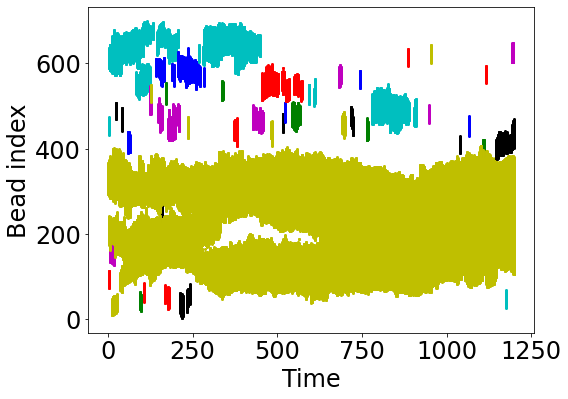

In [21]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

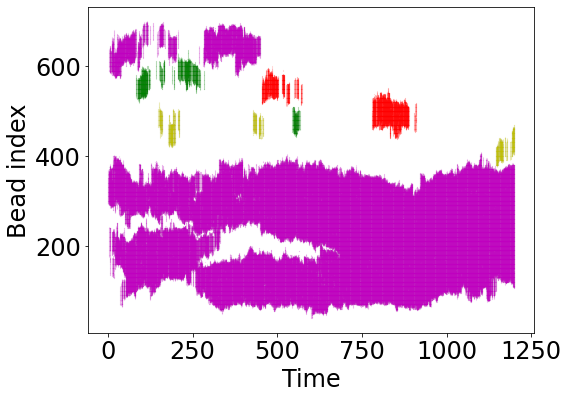

In [51]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

(0.0, 700.0)

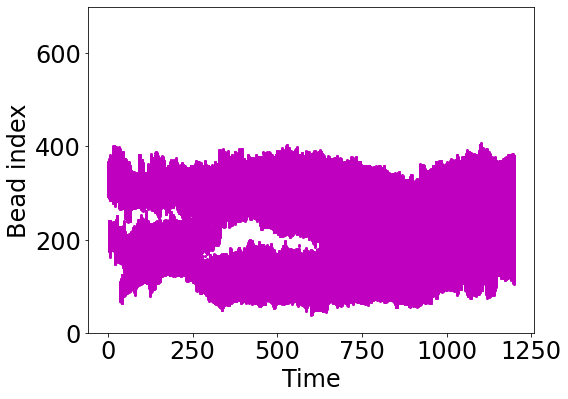

In [34]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)

for clust in biggest_tree.clusters:
    _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color)

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

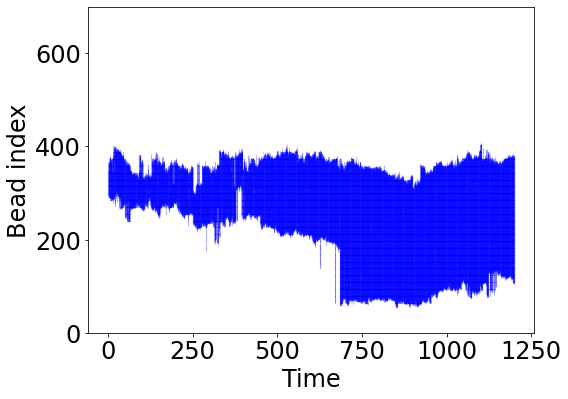

In [50]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_main_clust_branch()

for clust in biggest_tree.get_main_clust_branch():
    _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

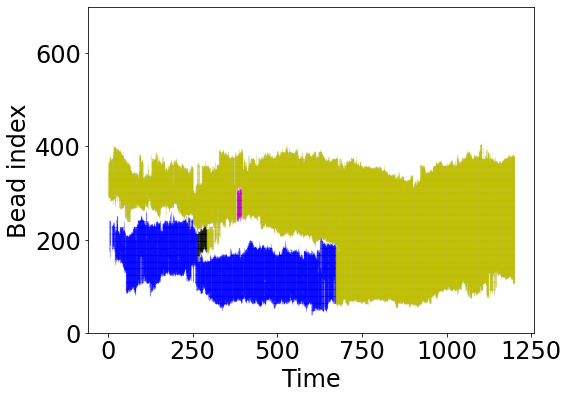

In [49]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    if len(branch_clusters) < 20:
        continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [7]:
data_path = (ceph_path /"21_aLchr1_700_runs/21-10-18_aLchr1_line700_2xsticky_conf")

In [53]:
# Get cluster data
# data_path = ceph_path / "22-07-15_aLc1_line16000_100umconf"
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
# data_path = (
#     ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                            :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust_cent_list = []
    clust_label_list = []
    for i in range(time_arr.size):
        clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
            com_arr[:, :, i], thresh=40)
        clust_cent_list += [cluster_centers]
        clust_label_list += [cluster_label_inds]

data_dict = {
    "time_arr": time_arr.tolist(),
    "cluster_center_list" : [[c.tolist() for c in t] for t in clust_cent_list],
    "cluster_label_list" : [[c.tolist() for c in t] for t in clust_label_list],
}
# Took 36m 27sec

number of estimated clusters : 4
number of thresholded clusters : 0
number of estimated clusters : 4
number of thresholded clusters : 0
number of estimated clusters : 8
number of thresholded clusters : 0
number of estimated clusters : 6
number of thresholded clusters : 0
number of estimated clusters : 9
number of thresholded clusters : 0
number of estimated clusters : 11
number of thresholded clusters : 0
number of estimated clusters : 12
number of thresholded clusters : 0
number of estimated clusters : 11
number of thresholded clusters : 0
number of estimated clusters : 14
number of thresholded clusters : 1
number of estimated clusters : 11
number of thresholded clusters : 0
number of estimated clusters : 10
number of thresholded clusters : 1
number of estimated clusters : 11
number of thresholded clusters : 1
number of estimated clusters : 12
number of thresholded clusters : 2
number of estimated clusters : 10
number of thresholded clusters : 2
number of estimated clusters : 12
numbe

In [54]:
# with (data_path / 'analysis/clust_data.yaml').open('w') as yf:
#     yaml.dump(data_dict, yf)

In [18]:
data_path = (
    ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")
with (data_path / 'analysis/clust_data.yaml').open('r') as yf:
    data_dict = yaml.safe_load(yf)
time_arr = np.array(data_dict['time_arr'])
cluster_center_list = data_dict['cluster_center_list']
cluster_label_list = data_dict['cluster_label_list']


In [25]:
print(len(cluster_center_list))

99


In [19]:

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_list[i]:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=50)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


In [39]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(12000)
print(sys.getrecursionlimit())

3000
12000


99


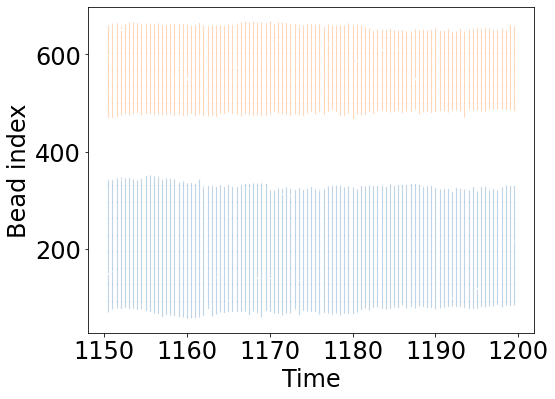

In [24]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
print(len(clusters))

for tree, color in zip(trees, colors):
    for clust in tree.clusters:
        # print(clust.time)
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color,s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

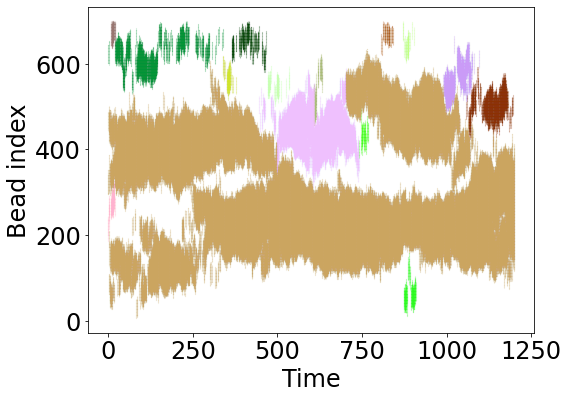

In [38]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

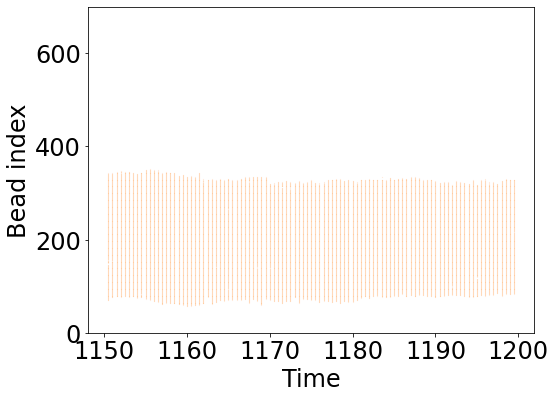

In [26]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)

for clust in biggest_tree.clusters:
    _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color,  s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

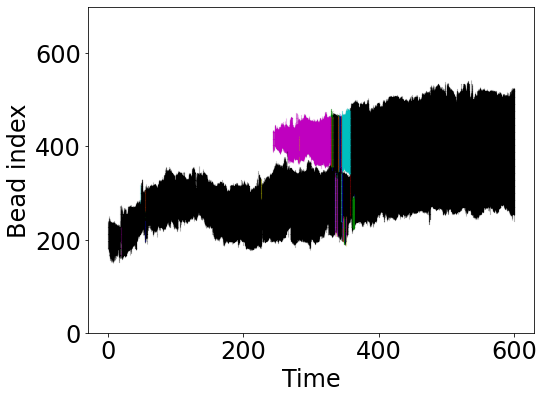

In [23]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    # if len(branch_clusters) < 20:
    #     continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

## Make cluster hdf5 file

In [6]:
t0 = time.time()
data_path = (ceph_path /"22-07-15_aLc1_line16000_100umconf")
with (data_path / 'analysis/clust_data.yaml').open('r') as yf:
    data_dict = yaml.safe_load(yf)
time_arr = np.array(data_dict['time_arr'])
cluster_center_list = data_dict['cluster_center_list']
cluster_label_list = data_dict['cluster_label_list']
t1 = time.time()
print(f'Read file {t1-t0}')

clusters = []
id_gen = aa.helpers.gen_id()

# Create cluster objects and possible descendants and progenitors
for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds, clust_cent in zip(cluster_label_list[i], cluster_center_list):
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds, clust_cent)]
t2 = time.time()
print(f'Created clusters {t2-t1}')


Read file 136.5832076072693
Created clusters 0.06189441680908203


AttributeError: 'list' object has no attribute 'write_clust_to_hdf5_dset'

In [14]:
t2 = time.time()
h5_clust_file = (data_path /'analysis/clust_data.h5')
h5_clust_file.unlink()
with h5py.File(h5_clust_file, 'w') as h5_data:
    h5_data.create_dataset('time', data=time_arr)
    clust_grp = h5_data.create_group('clusters')
    for t, cg in zip(time_arr[1:], clusters[1:]):
        time_grp = clust_grp.create_group(f'time_{t}')
        time_grp.attrs['time'] = t
        for c in cg:
            c.write_clust_to_hdf5_dset(time_grp)
t3 = time.time()
print(f'Wrote clusters {t3-t2}')


<HDF5 dataset "time": shape (439,), type "<f8">

Wrote clusters 48.534268379211426


In [26]:
t3 = time.time()
data_path = (ceph_path /"22-07-15_aLc1_line16000_100umconf")
h5_clust_file = (data_path /'analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = [[]]
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
    # clust_grp = h5_data.create_group('clusters')
t4 = time.time()
print(f'Read clusters {t4-t3}')


Read clusters 8.417649030685425


In [27]:
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=40)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

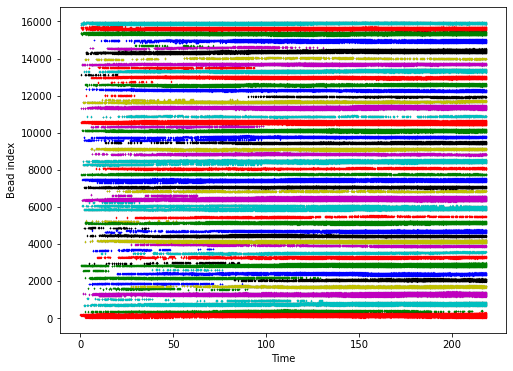

In [28]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [5]:
h5_clust_file = (ws_path/ '22-04-01_aLchr1_scan.12_line700_2xsticky_rigid700_5umconf/simulations/s6/analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
    # clust_grp = h5_data.create_group('clusters')
t4 = time.time()
#print(f'Read clusters {t4-t3}')
#print(clusters)
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=40)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]



In [6]:
print(len(tree.clusters))

2386


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


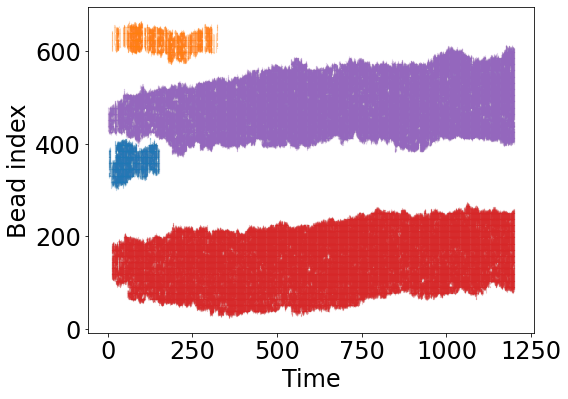

In [7]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

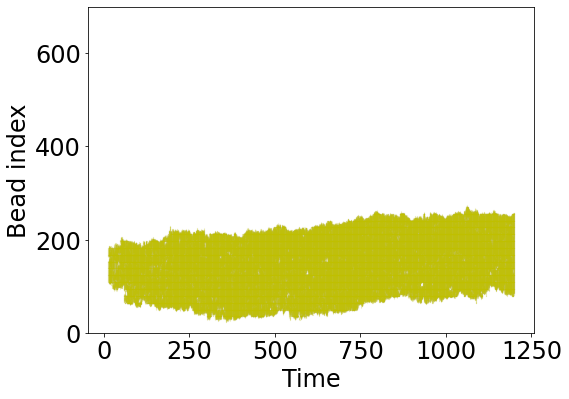

In [80]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    # if len(branch_clusters) < 20:
    #     continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [27]:
h5_clust_file = (ceph_path/ '22_aLchr700_sticky_runs/22-01-06_aLchr1_scan8.12_line700_2xsticky_4umconf_ko.1-300/simulations/kod300/s1/analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
    # clust_grp = h5_data.create_group('clusters')
t4 = time.time()
#print(f'Read clusters {t4-t3}')
#print(clusters)
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=40)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


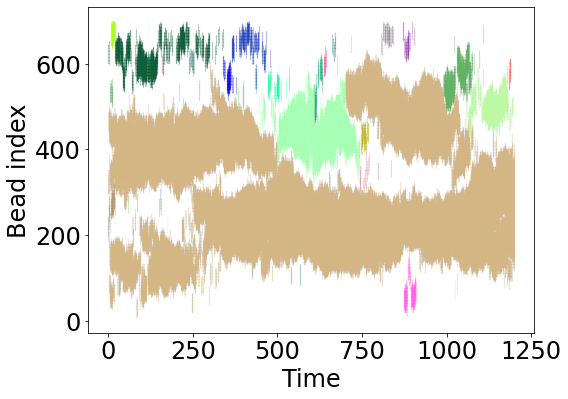

In [37]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    # if len(tree.clusters) < 20:
    #     continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

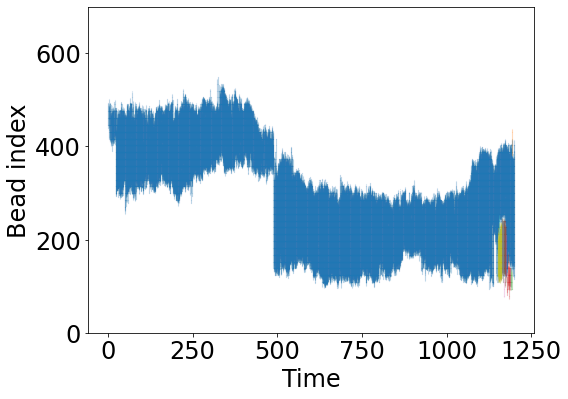

In [29]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    # if len(branch_clusters) < 20:
    #     continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [12]:
h5_clust_file = (ws_path/ '22-04-01_aLchr1_scan.12_line700_2xsticky_rigid700_5umconf/simulations/s12/analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
    # clust_grp = h5_data.create_group('clusters')
t4 = time.time()
#print(f'Read clusters {t4-t3}')
#print(clusters)
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=40)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


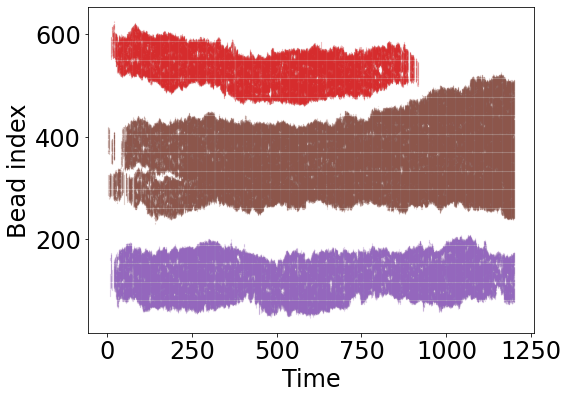

In [13]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for tree, color in zip(trees, colors):
    if len(tree.clusters) < 20:
        continue
    for clust in tree.clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

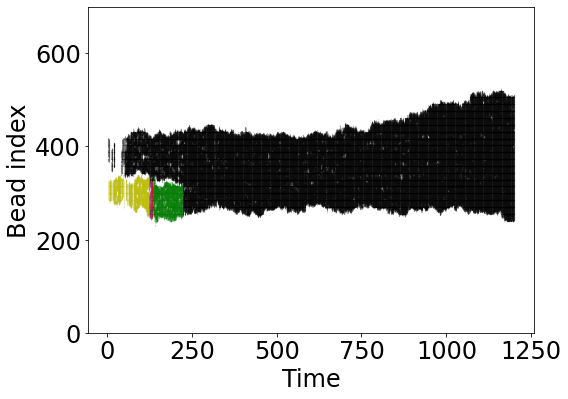

In [89]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
_ = axarr.set_ylim(0,700)

biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()


for root, color in zip(branch_roots, colors):
    branch_clusters = root.get_largest_branch()
    # if len(branch_clusters) < 20:
    #     continue
    for clust in branch_clusters:
        _ = axarr.scatter([clust.time]*len(clust.part_ids), clust.part_ids, color = color, s= .01, marker='.')

_ = axarr.set_ylabel("Bead index")
_ = axarr.set_xlabel("Time")

In [ ]:

h5_clust_file = (ws_path/ '22-04-01_aLchr1_scan.12_line700_2xsticky_rigid700_5umconf/simulations/s12/analysis/clust_data.h5')
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]
    # clust_grp = h5_data.create_group('clusters')
t4 = time.time()
#print(f'Read clusters {t4-t3}')
#print(clusters)
root_clusters = cla.find_descendants(clusters, thresh=.4, nskip=40)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]
